In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")



In [2]:
train_data = pd.read_csv('Data/store-sales-time-series-forecasting/train.csv')
test_data = pd.read_csv('Data/store-sales-time-series-forecasting/test.csv')
oil_data = pd.read_csv('Data/store-sales-time-series-forecasting/oil.csv')
transactions_data = pd.read_csv('Data/store-sales-time-series-forecasting/transactions.csv')
holidays_data = pd.read_csv('Data/store-sales-time-series-forecasting/holidays_events.csv')
stores_data = pd.read_csv('Data/store-sales-time-series-forecasting/stores.csv')


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None

Train Data Summary:
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e

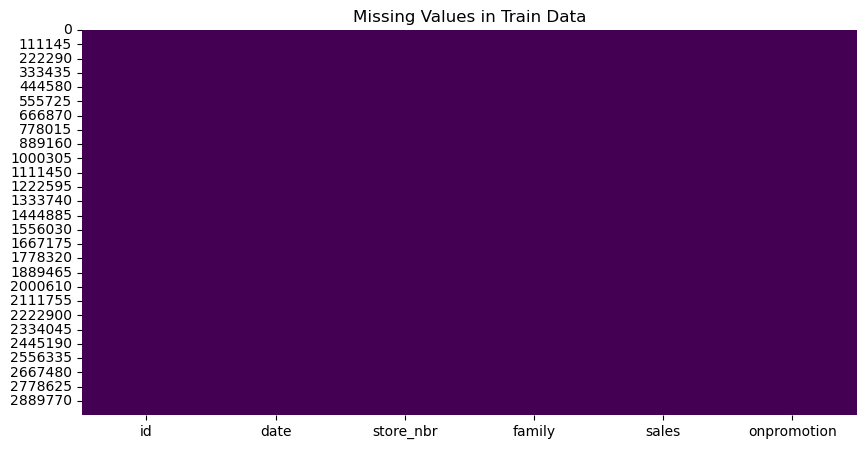

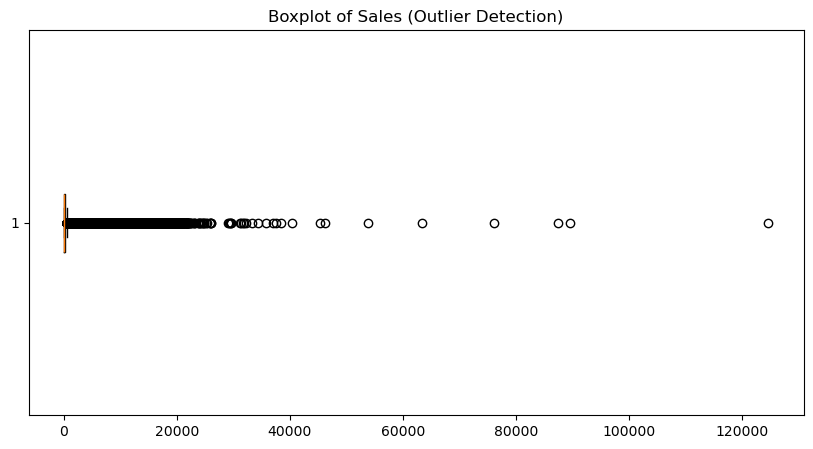

In [3]:
# Preliminary Data Exploration
# Display basic information about the datasets
print("Train Data Info:")
print(train_data.info())
print("\nTest Data Info:")
print(test_data.info())

# Display summary statistics
print("\nTrain Data Summary:")
print(train_data.describe())

# Check for missing values
print("\nMissing Values in Train Data:")
print(train_data.isnull().sum())

print("\nMissing Values in Oil Data:")
print(oil_data.isnull().sum())

# Visualizing missing values
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Train Data")
plt.show()

# Check for anomalies and outliers
plt.figure(figsize=(10, 5))
plt.boxplot(train_data['sales'], vert=False)
plt.title("Boxplot of Sales (Outlier Detection)")
plt.show()

# Data Cleaning

In [4]:

# Handling missing values
train_data.fillna(method='ffill', inplace=True)  # Forward fill method for missing data
oil_data.fillna(method='ffill', inplace=True)

# Removing outliers using the IQR method
Q1 = train_data['sales'].quantile(0.25)
Q3 = train_data['sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out extreme outliers
train_data = train_data[(train_data['sales'] >= lower_bound) & (train_data['sales'] <= upper_bound)]



print("\nData Cleaning Completed: Missing values handled, and outliers removed.")


Data Cleaning Completed: Missing values handled, and outliers removed.


# Exploratory Data Analysis (EDA)


Detailed Statistical Summary:
                  id        date     store_nbr      family         sales  \
count   2.553783e+06     2553783  2.553783e+06     2553783  2.553783e+06   
unique           NaN        1684           NaN          33           NaN   
top              NaN  2013-01-01           NaN  AUTOMOTIVE           NaN   
freq             NaN        1780           NaN       90936           NaN   
mean    1.472429e+06         NaN  2.732917e+01         NaN  5.874689e+01   
std     8.682923e+05         NaN  1.537488e+01         NaN  1.065165e+02   
min     0.000000e+00         NaN  1.000000e+00         NaN  0.000000e+00   
25%     7.159535e+05         NaN  1.400000e+01         NaN  0.000000e+00   
50%     1.457348e+06         NaN  2.700000e+01         NaN  5.000000e+00   
75%     2.223852e+06         NaN  4.000000e+01         NaN  6.108500e+01   
max     3.000887e+06         NaN  5.400000e+01         NaN  4.896150e+02   

         onpromotion  
count   2.553783e+06  
unique    

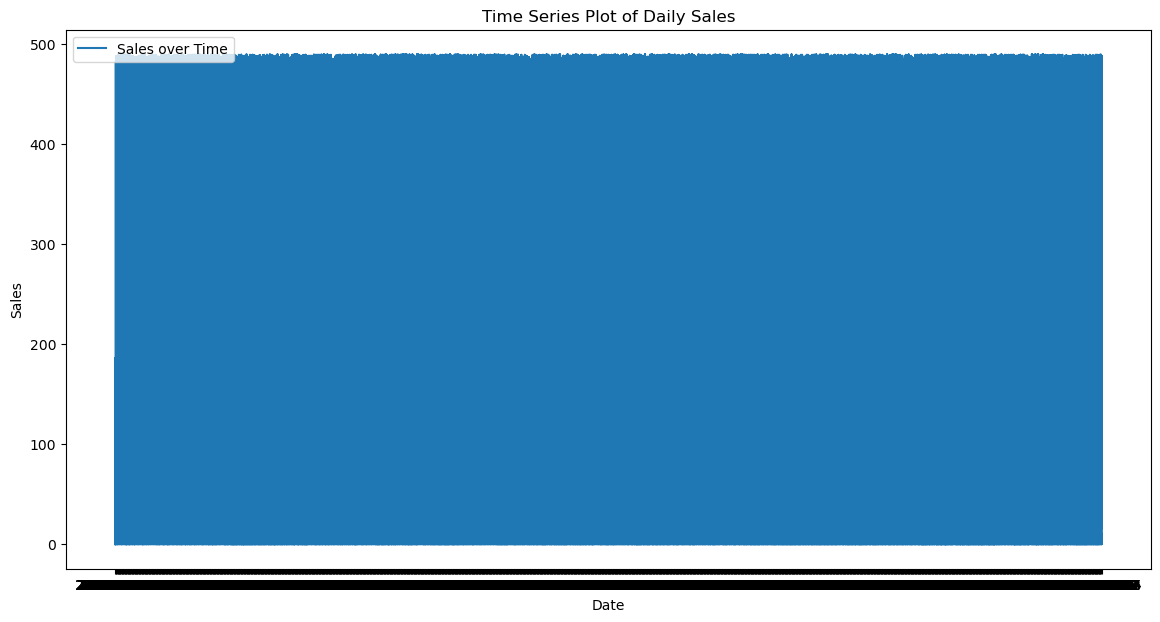

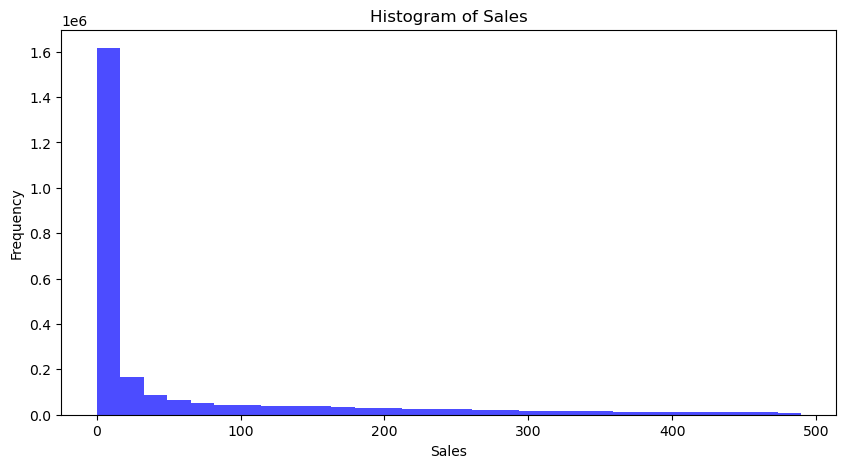

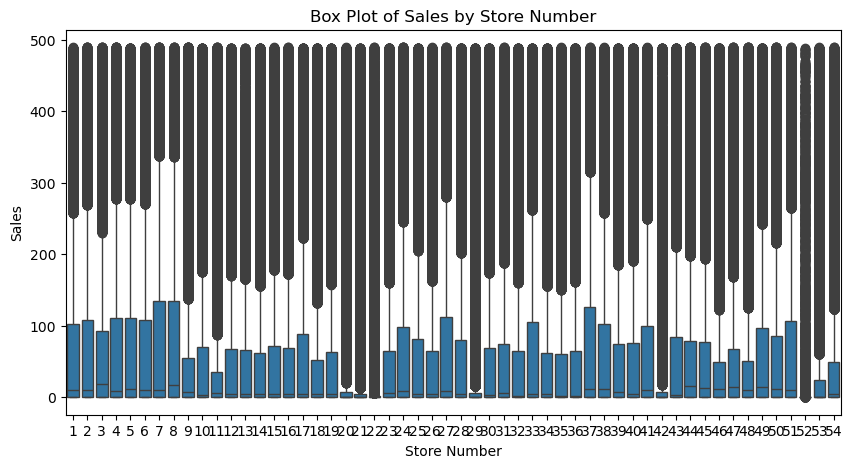

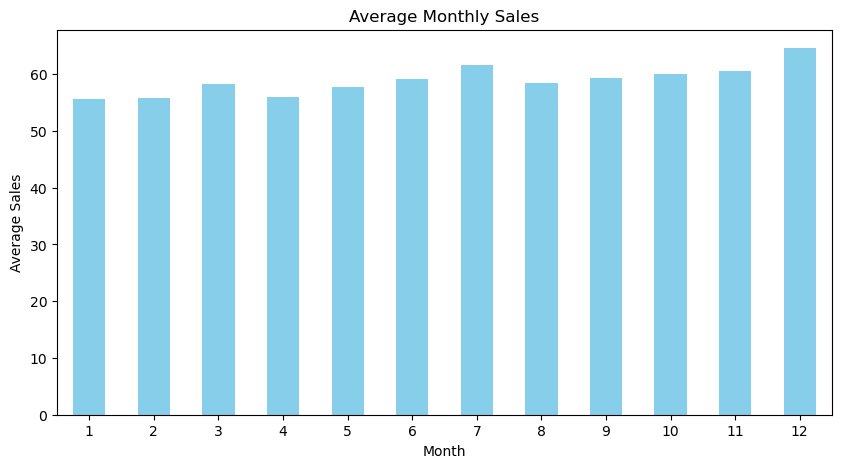

In [5]:
# Statistical Summary
print("\nDetailed Statistical Summary:")
print(train_data.describe(include='all'))

# Visualization
# Time Series Plot
plt.figure(figsize=(14, 7))
plt.plot(train_data['date'], train_data['sales'], label='Sales over Time')
plt.title('Time Series Plot of Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Histogram of Sales
plt.figure(figsize=(10, 5))
plt.hist(train_data['sales'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Box Plot by Store Type
plt.figure(figsize=(10, 5))
sns.boxplot(x='store_nbr', y='sales', data=train_data)
plt.title('Box Plot of Sales by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Sales')
plt.show()

# Seasonality Visualization with Monthly Averages
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['month'] = train_data['date'].dt.month
monthly_sales = train_data.groupby('month')['sales'].mean()

plt.figure(figsize=(10, 5))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.show()

In [8]:
train_data

,id,store_nbr,family,sales,onpromotion,month,fitted
date,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0,1,0.000000
2013-01-01,1,1,BABY CARE,0.000,0,1,0.000000
2013-01-01,2,1,BEAUTY,0.000,0,1,0.000000
2013-01-01,3,1,BEVERAGES,0.000,0,1,0.000000
2013-01-01,4,1,BOOKS,0.000,0,1,0.000000
...,...,...,...,...,...,...,...
2017-08-15,3000882,9,PLAYERS AND ELECTRONICS,6.000,0,8,78.190393
2017-08-15,3000883,9,POULTRY,438.133,0,8,78.173916
2017-08-15,3000884,9,PREPARED FOODS,154.553,1,8,80.818933


# ETS Model

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [16]:
# Model Building
train_data.set_index('date', inplace=True)
ets_model = ExponentialSmoothing(train_data['sales'], trend='add', seasonal='add', seasonal_periods=12).fit()



Text(0.5, 1.0, 'Sales and Fitted Values')

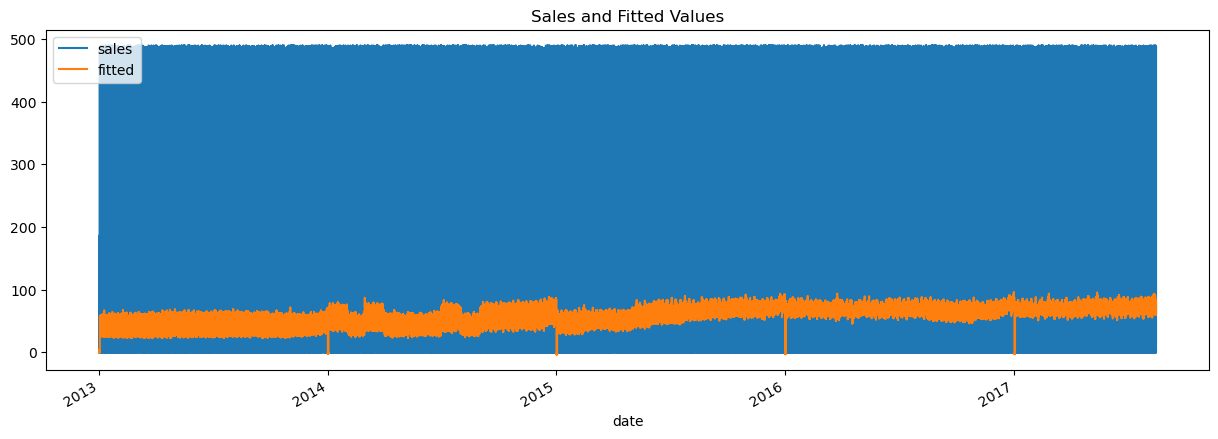

In [17]:
# Model Diagnostics
train_data['fitted'] = ets_model.fittedvalues
train_data[['sales', 'fitted']].plot(figsize=(15, 5))
plt.title('Sales and Fitted Values')


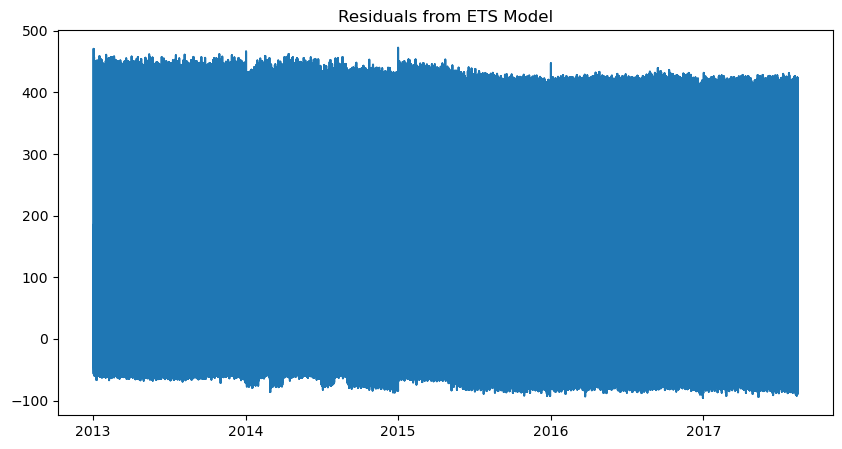

In [18]:

# Check residuals
residuals = ets_model.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals from ETS Model')
plt.show()


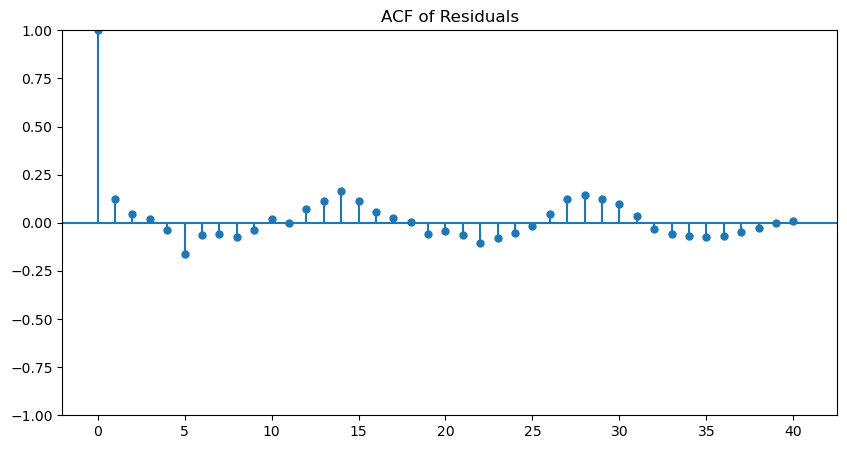

In [19]:

# ACF and PACF plots of residuals
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.show()


ACF plot reveals significant autocorrelation, indicating that the model needs improvement.

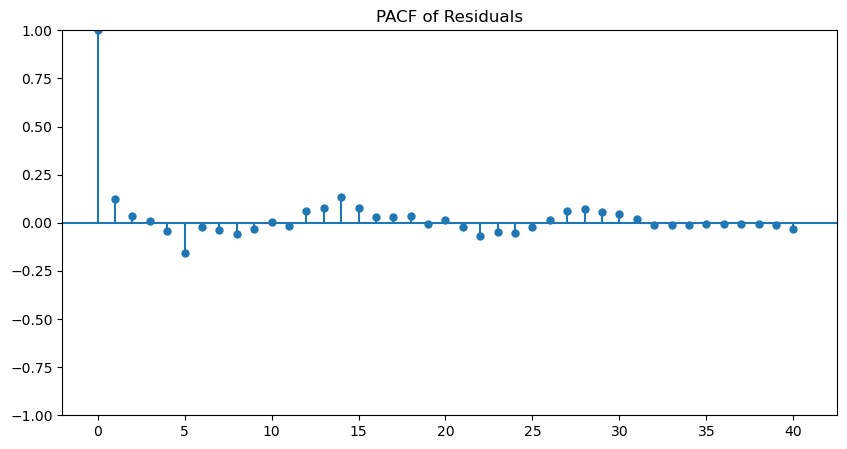

ETS Model Summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    sales   No. Observations:              2553783
Model:             ExponentialSmoothing   SSE                    28725151780.540
Optimized:                         True   AIC                       23821598.768
Trend:                         Additive   BIC                       23821802.817
Seasonal:                      Additive   AICC                      23821598.768
Seasonal Periods:                    12   Date:                 Sat, 08 Feb 2025
Box-Cox:                          False   Time:                         16:44:59
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0050000                alpha                 True
smooth

In [21]:

plt.figure(figsize=(10, 5))
plot_pacf(residuals, lags=40, ax=plt.gca())
plt.title('PACF of Residuals')
plt.show()

# Interpretation
print("ETS Model Summary:")
print(ets_model.summary())




In [22]:
print('Evaluation and Interpretation started')
# Shapiro-Wilk Test
shapiro_test = shapiro(residuals)
print(f'Shapiro-Wilk Test: Statistic={shapiro_test[0]}, p-value={shapiro_test[1]}')

Evaluation and Interpretation started
Shapiro-Wilk Test: Statistic=0.6661484195133238, p-value=7.89472585517938e-206


In [23]:
## Independence of Residuals
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat}')

Durbin-Watson statistic: 1.7535229256322884


Text(0, 0.5, 'Residuals')

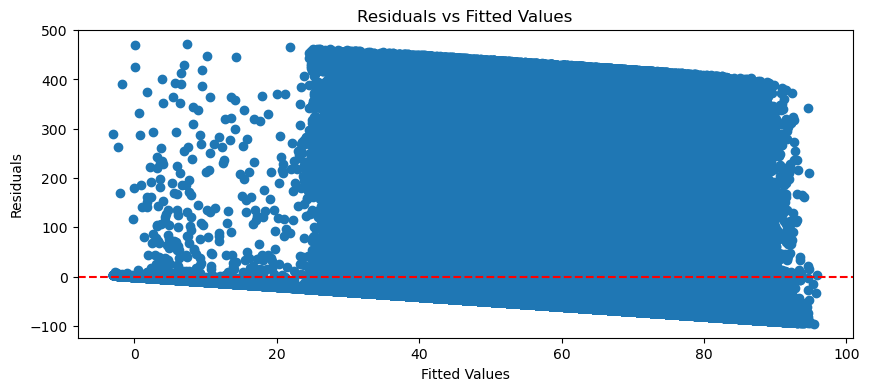

In [25]:
## Homoscedasticity
plt.figure(figsize=(10, 4))
plt.scatter(ets_model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

# Submission File for ETS Model

In [31]:
import pandas as pd

# Example: Creating a date range from a known start date for a given number of periods
start_date = '2021-01-01'  # Adjust the start date to match your dataset specifics
periods = len(test_data)  # Number of periods from the length of your test data
frequency = 'D'  # Daily frequency; adjust as needed (e.g., 'M' for monthly)

date_range = pd.date_range(start=start_date, periods=periods, freq=frequency)
test_data['date'] = date_range  # Adding the date range to the test data
test_data.set_index('date', inplace=True)  # Setting 'date' as the index


In [32]:
# Forecast future sales for the length of the test dataset
forecast_periods = len(test_data)
forecast = ets_model.forecast(steps=forecast_periods)

# Prepare submission file
submission = pd.DataFrame({
    "id": test_data['id'],  # Ensure 'id' is in your DataFrame as shown in columns
    "sales": forecast
})

# Save to CSV
submission.to_csv('ETS_StoreSales_submission.csv', index=False)
print("Submission file ready and saved as 'ETS_StoreSales_submissio.csv'.")


Submission file ready and saved as 'ETS_StoreSales_submissio.csv'.


# Model Tuning

In [33]:
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro



In [34]:

# Function to perform ADF test
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] > 0.05:
        print("Time series is not stationary")
    else:
        print("Time series is stationary")

# Function to test for seasonality and decompose the time series
def test_seasonality_and_decompose(timeseries, period):
    decomposition = seasonal_decompose(timeseries, period=period, model='additive')
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
    decomposition.trend.plot(ax=ax1)
    ax1.set_title('Trend')
    decomposition.seasonal.plot(ax=ax2)
    ax2.set_title('Seasonality')
    decomposition.resid.plot(ax=ax3)
    ax3.set_title('Residuals')
    plt.tight_layout()
    plt.show()

    # Additional checks and explanations
    if decomposition.trend.isna().sum() > 0:
        print("Trend component has missing values which may affect the accuracy of the model.")
    if decomposition.resid.isna().sum() > 0:
        print("Residual component has missing values. Consider examining outliers or anomalies in the data.")


In [35]:

# Define parameter grid
param_grid = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'seasonal_periods': [12]  # Assuming monthly data; adjust as necessary
}

# Wrap ETSModel for GridSearch
def ets_fit(train_data, trend, seasonal, seasonal_periods):
    model = ETSModel(
        train_data['sales'],
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods
    ).fit()
    return model




In [36]:
# Grid search to find the best model parameters
best_score = float("inf")
best_params = None
for trend in param_grid['trend']:
    for seasonal in param_grid['seasonal']:
        try:
            model = ets_fit(train_data, trend, seasonal, param_grid['seasonal_periods'])
            if model.aic < best_score:
                best_score = model.aic
                best_params = {'trend': trend, 'seasonal': seasonal, 'seasonal_periods': param_grid['seasonal_periods']}
        except Exception as e:
            print(f"Error with parameters {trend}, {seasonal}: {str(e)}")

print("Best Model Parameters:", best_params)


Error with parameters add, add: seasonal_periods must be integer_like (int or np.integer, but not bool or timedelta64) or None
Error with parameters add, mul: seasonal_periods must be integer_like (int or np.integer, but not bool or timedelta64) or None
Error with parameters mul, add: seasonal_periods must be integer_like (int or np.integer, but not bool or timedelta64) or None
Error with parameters mul, mul: seasonal_periods must be integer_like (int or np.integer, but not bool or timedelta64) or None
Error with parameters mul, None: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Error with parameters None, add: seasonal_periods must be integer_like (int or np.integer, but not bool or timedelta64) or None
Error with parameters None, mul: seasonal_periods must be integer_like (int or np.integer, but not bool or timedelta64) or None
Best Model Parameters: {'trend': None, 'seasonal': None, 'seasonal_periods': [12]}


In [37]:
# Refit the model with the best parameters
final_model = ets_fit(train_data, **best_params)

In [38]:

# Assuming test_data is properly prepared and includes a column 'id'
def create_submission(model, test_data, filename='ETS_submission.csv'):
    # Forecast future sales for the length of the test dataset
    forecast_periods = len(test_data)
    forecast = model.forecast(steps=forecast_periods)
    
    # Create a DataFrame for submission
    submission = pd.DataFrame({
        'id': test_data['id'],
        'sales': forecast
    })
    
    # Save the DataFrame to a CSV file
    submission.to_csv(filename, index=False)
    print(f"Submission file '{filename}' is ready!")



In [41]:
# Check stationarity and seasonality before applying models
train_data['sales'] = train_data['sales'].astype('float32')
test_stationarity(train_data['sales'])
print("Testing stationarity of the time series data:")


MemoryError: Unable to allocate 2.91 GiB for an array with shape (2553934, 153) and data type float64

Testing for seasonality and decomposing the time series data:


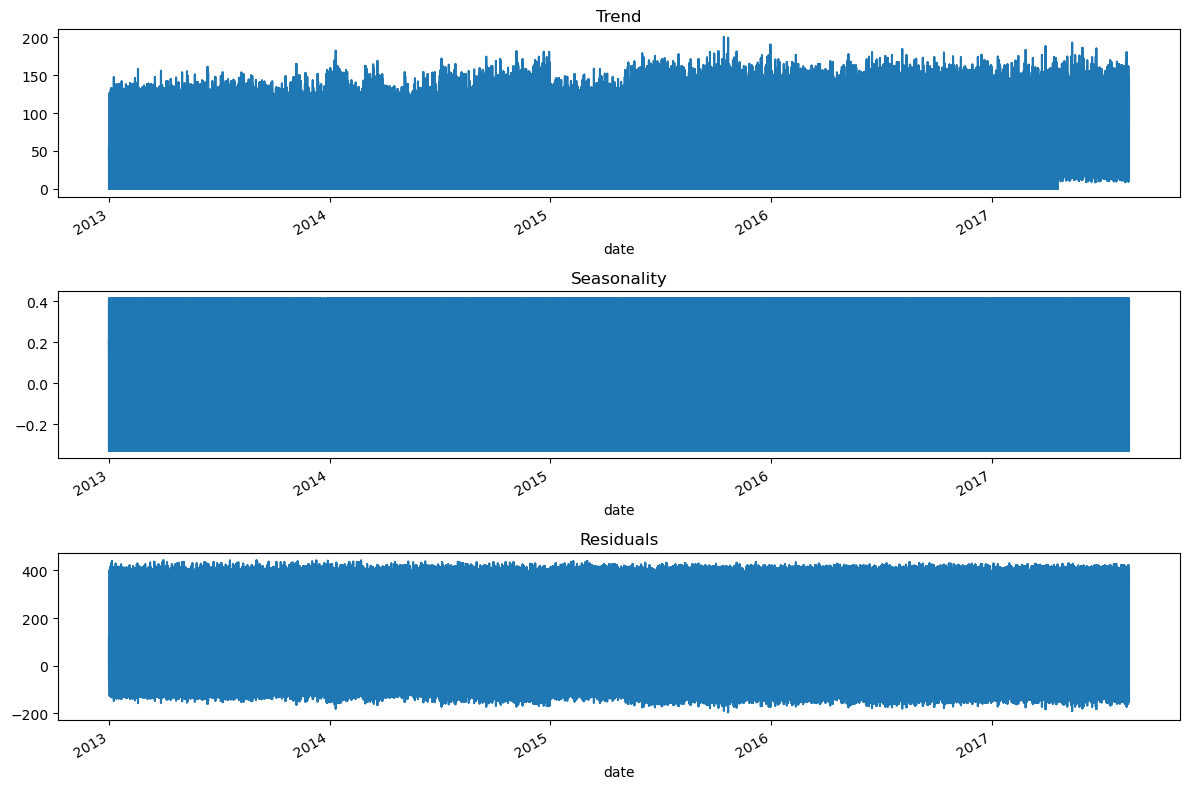

Trend component has missing values which may affect the accuracy of the model.
Residual component has missing values. Consider examining outliers or anomalies in the data.


In [42]:
print("Testing for seasonality and decomposing the time series data:")
test_seasonality_and_decompose(train_data['sales'], param_grid['seasonal_periods'][0])



In [43]:
# Apply final model to create submission file
create_submission(final_model, test_data)

Submission file 'ETS_submission.csv' is ready!


# Final Interpretation

In [ ]:
def interpret_model(model):
    print("Final Model Summary:")
    print(model.summary())
    # Add more specific interpretations based on coefficients or model attributes
    print("Interpretation of Model Effects:")
    # Example:
    if 'trend' in model.params:
        print(f"The model identified a {'positive' if model.params['trend'] > 0 else 'negative'} trend in sales over time.")

# Run interpretation function
interpret_model(final_model)


# ARIMA Model

In [24]:
# Calculate the number of rows to include in the train set
train_size = int(len(train_data) * 0.15)

# Split the DataFrame
train_data = train_data[:train_size]

The 'sales' data is constant; ARIMA modeling may not be applicable.


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt

# Check stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())  # dropna() handles missing values
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Apply stationarity test
test_stationarity(train_data['sales'])

train_data['sales_diff'] = train_data['sales'] - train_data['sales'].shift(1)
test_stationarity(train_data['sales_diff'])

# Split data into training and testing sets
split_point = int(len(train_data) * 0.8)  # 80% for training, 20% for testing
train, test = train_data['sales_diff'].iloc[:split_point], train_data['sales_diff'].iloc[split_point:]

# Fit ARIMA model (example: ARIMA(1,1,1))
model = ARIMA(train.dropna(), order=(1,1,1))  # Ensure to dropna() to handle any NaNs from differencing
fitted_model = model.fit()

# Forecast
pred = fitted_model.get_forecast(steps=len(test))
fc = pred.predicted_mean
conf = pred.conf_int(alpha=0.05)

# Plotting the forecast against actual outcomes
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Data')
plt.plot(test.index, fc, label='Forecasted Data')
plt.fill_between(test.index, conf.iloc[:, 0], conf.iloc[:, 1], color='k', alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# Print model summary to check for diagnostics
print(fitted_model.summary())

In [49]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Assuming your model is named `fitted_model` and is ready
# Let's forecast the sales
forecast_periods = len(test_data)
predicted_sales = fitted_model.get_forecast(steps=forecast_periods)
forecasted_sales = predicted_sales.predicted_mean

# Since the test data index is date and you need to match 'id' with sales
forecasted_sales.index = test_data['id']

# Handling any potential NaN values in forecasted sales
forecasted_sales.fillna(0, inplace=True)  # Replace NaNs with 0, adjust based on requirements

# Create the submission DataFrame
submission_df = pd.DataFrame({
    "id": forecasted_sales.index,
    "sales": forecasted_sales.values
})

# Ensure no missing IDs or sales in the final DataFrame
submission_df['id'] = submission_df['id'].astype(int)  # Make sure IDs are integer type
submission_df.dropna(subset=['sales'], inplace=True)  # Drop rows where sales are NaN if any exist

# Save to CSV
submission_df.to_csv('Kaggle_Store_Sales_Submission.csv', index=False)
print("Submission file is ready!")
print(submission_df.head())


Submission file is ready!
        id     sales
0  3000888  2.629281
1  3000889 -1.382052
2  3000890  0.727032
3  3000891 -0.381885
4  3000892  0.201163
